![logo](../img/LogoLine_horizon_C3S.png)

# Demonstration on how to plot  ozone datasets on the CDS. 

In this notebook we will show a practical example on how to download ozone products from the CDS within python. After retrieving the files we will also take a look at the content of the files by plotting the dataset. We will show two use cases, but it is obvious that more complex plots can be constructed in a similar way. 

First we start by importing the needed libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import datetime as dt
import xarray 
import pandas as pd
import cads_toolbox as ct
ct.config.USE_CACHE = False 

## time series of ozone

In this example we download the gto_ecv product, which is a long-term merged total ozone data product covering the period from January 1996 until today. Therefore we first have to provide a 'request' structure. 

In [4]:
request=['satellite-ozone-v1',
         {'processing_level': 'level_3',
          'variable': 'atmosphere_mole_content_of_ozone',
       'vertical_aggregation': 'total_column',
          'sensor': 'merged_uv',
          'year': [f'{y:04d}' for y in range(2000,2022)],
          'month': [f'{m:02d}' for m in range(1,12)],
          'version': 'v0800'}]


The above pythonic structure can also be found on https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-ozone-v1?tab=form by choosing the desired fields and clicking on *show toolbox request*.     

Making the ozone dataset accessible in our python script goes as follows:

In [5]:
remote =ct.catalogue.retrieve(*request)     

Then we convert to a list of xarray objects by using *to_xarray()* 

In [6]:
dataset=remote.to_xarray()

2023-04-18 17:44:47,789 INFO Welcome to the CDS
2023-04-18 17:44:47,791 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-ozone-v1
2023-04-18 17:44:48,091 INFO Request is queued
2023-04-18 17:44:49,129 INFO Request is running
2023-04-18 17:49:06,553 INFO Request is completed
2023-04-18 17:49:06,555 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data3/dataset-satellite-ozone-v1-91186164-e343-4dbf-a7a9-78f90bc599a0.zip to dataset-satellite-ozone-v1-91186164-e343-4dbf-a7a9-78f90bc599a0.zip (194.3M)
2023-04-18 17:49:11,090 INFO Download rate 42.9M/s 
/home/michelv/.local/lib64/python3.9/site-packages/emohawk/readers/__init__.py:71: UserWarning: Error loading reader json
  warnings.warn(f"Error loading reader {name}")


convert to Dobson units (DU) by using the conversion attribute *multiplication_factor_to_convert_to_DU* :

In [7]:
for x in dataset:
    x['total_ozone_column']=x['total_ozone_column']*x['total_ozone_column'].multiplication_factor_to_convert_to_DU 

The next statement concatenates all monthly datafiles, thereby introducing a new time dimension. 

In [8]:
dataset=xarray.concat([x.mean(dim='longitude',skipna=True) for x in dataset],pd.Index([dt.datetime.strptime(x.time_coverage_start,"%Y%m%d") for x in dataset], name='date'))

calling the xarray wrapper of the function *matplotlib.pyplot.pcolormesh* for plotting. Furthermore labels of the axes are set and a colorbar with appriopriate scale is added. 

/bira-iasb/softs/21g/py39/lib64/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


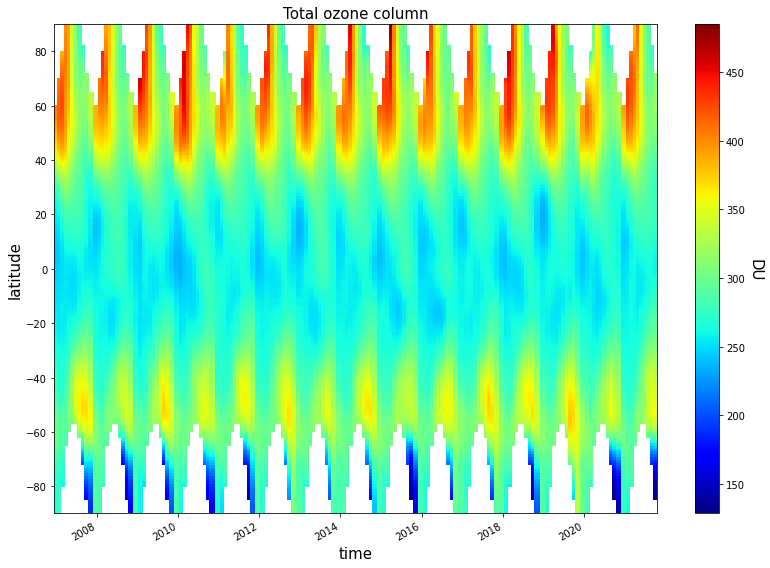

In [9]:
dataset=dataset.transpose()
o3plot=dataset['total_ozone_column'].plot(cmap='jet',add_labels=False,add_colorbar=False,size=9)
ax = plt.gca()
ax.set_xlabel("time", fontsize=15)
ax.set_ylabel("latitude", fontsize=15)
ax.set_title("Total ozone column", fontsize=15)
cbar = plt.colorbar(o3plot)
cbar.set_label('DU', rotation=270,fontsize=15,labelpad=18)
plt.show()

In this plot we clearly see the seasonal variations in total ozone, which are driven by dynamical effects as well as by polar chemistry. The signature of the  ozone hole can be clearly identified each year during the Austral Spring season. These data can be analysed to study the variability and trends in total ozone at global and regional scales.

## Plotting an ozone distribution on a map. 



In [10]:
request=['satellite-ozone-v1',
       {'processing_level': 'level_3',
        'variable': 'atmosphere_mole_content_of_ozone',
        'vertical_aggregation': 'total_column',
        'sensor': 'merged_uv',
        'year': '2021',
        'month': [f'{m:02d}' for m in range(1,13)],
        'version': 'v0900'}]

remote = ct.catalogue.retrieve(*request)
dataset2=remote.to_xarray() #convert to a list of xarray object, so no need to open file by file.

2023-04-18 17:51:24,533 INFO Welcome to the CDS
2023-04-18 17:51:24,534 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-ozone-v1
2023-04-18 17:51:24,574 INFO Request is queued
2023-04-18 17:51:25,619 INFO Request is running
2023-04-18 17:51:37,946 INFO Request is completed
2023-04-18 17:51:37,947 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data9/dataset-satellite-ozone-v1-d019b932-2c12-4d7e-bd4e-c5f7235cfa62.zip to dataset-satellite-ozone-v1-d019b932-2c12-4d7e-bd4e-c5f7235cfa62.zip (14M)
2023-04-18 17:51:38,629 INFO Download rate 20.6M/s  


Preparing the figure by defining the latitude/longitude boundaries of the maps and the corresponding projection. Choose between one of the two following code cells. (if the next one code block is chosen, pay attention that the code block that follows this one is not executed). 

In [11]:
proj=ccrs.SouthPolarStereo()
latlon_bounds=[-180, 180, -90, -60]

In [12]:
proj=ccrs.PlateCarree();
latlon_bounds=[-180, 180, -90, 90]

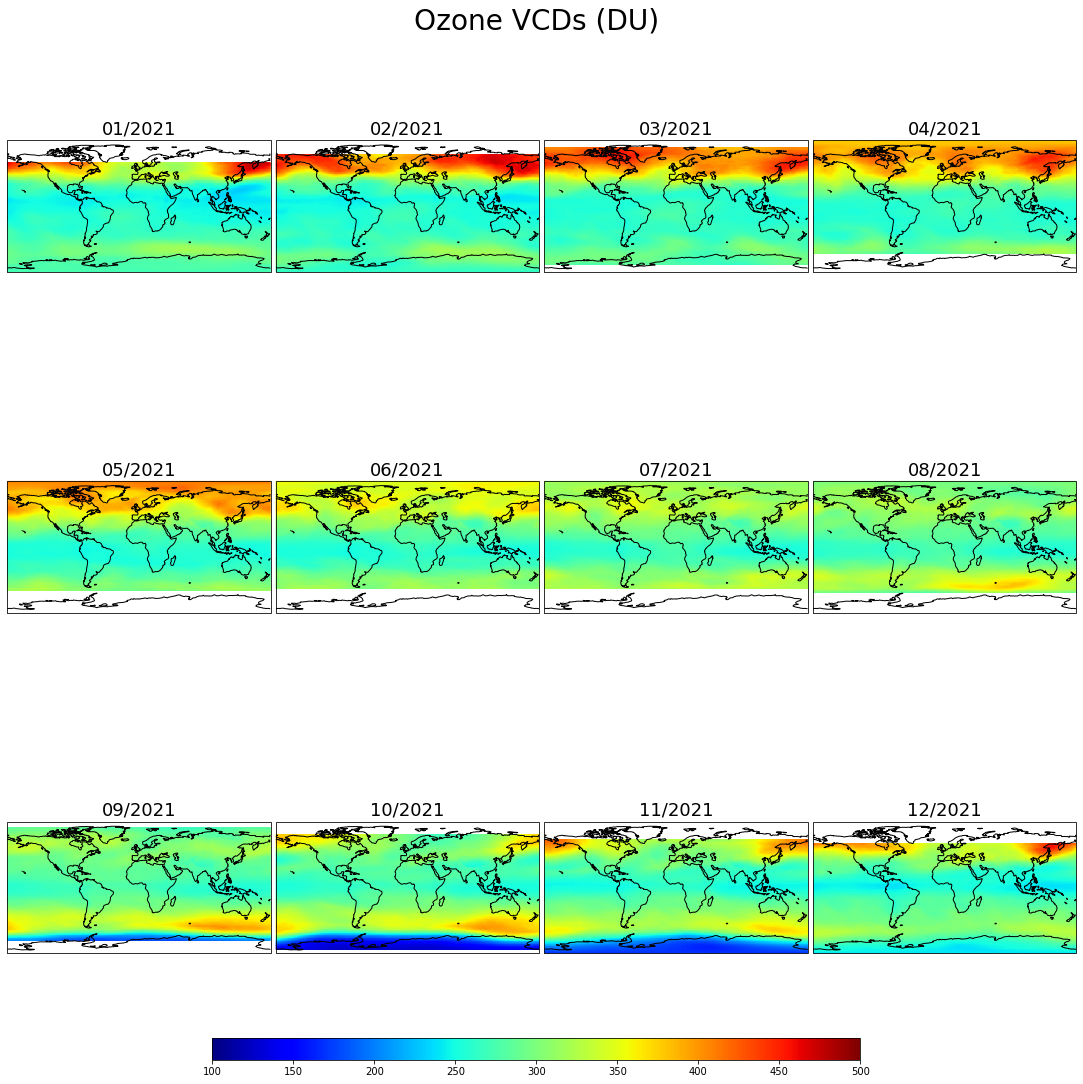

In [14]:
figure, axs = plt.subplots(nrows=3,ncols=4,figsize=(15,15),subplot_kw={'projection': proj});
axs=axs.flatten()
for x in axs:
    x.set_extent(latlon_bounds, crs=ccrs.PlateCarree())                
figure.suptitle("Ozone VCDs (DU)",fontsize=28)
for i,data in enumerate(dataset2): 
    o3=data['total_ozone_column'].to_numpy()*data['total_ozone_column'].multiplication_factor_to_convert_to_DU
    lat=data['latitude'].to_numpy()
    long=data['longitude'].to_numpy()
    dat=dt.datetime.strptime(data.time_coverage_start,"%Y%m%d")
    datstr=dt.datetime.strftime(dat,"%m/%Y")
    axs[i].coastlines()
    axs[i].set_title('{}'.format(datstr),fontsize=18) # update title with attribute time_coverage_start
    cs=axs[i].pcolormesh(long,lat,o3,shading='auto',cmap='jet',transform=ccrs.PlateCarree(),vmin=100,vmax=500)
figure.subplots_adjust(bottom=0.01, top=0.95, left=0.01, right=1.0,wspace=0.02, hspace=0.02)
cbar_ax = figure.add_axes([0.2, 0.005, 0.6, 0.02])
cbar=figure.colorbar(cs,cax=cbar_ax,ticks=np.arange(100,550,50),orientation='horizontal')
plt.show()

These plots illustrate the seasonal evolution of the global ozone distribution. Anomalies in Arctic stratospheric ozone are  particularly important in spring, when returning sunlight allows them to alter stratospheric temperatures via shortwave heating, thus modifying atmospheric dynamics. During the mid-latitude summer season and in the tropics, ozone columns are smaller and show less variability. The Southern hemisphere is characterised by the ozone hole, which develops each year in early spring (from September to November). 